In [1]:
import numpy as np
import time
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import zipfile
import os
import glob
import re
from datetime import timedelta

from sklearn.metrics import confusion_matrix
from sklearn import linear_model
import sklearn.tree as tree

# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

# 0 Load data

Load in cleaned dataset for feature selection and data modeling analysis

In [2]:
# datapath = '/3036336718_3036339721/data'
# datapath = '/content/drive/MyDrive/DataC200 Graduate Project/3036336718_3036339721/data/'

# figurepath = '/3036336718_3036339721/figures'
# figurepath = '/content/drive/MyDrive/DataC200 Graduate Project/3036336718_3036339721/figures/'

abspath = os.path.abspath(os.pardir)

datafolder = 'data/'

datapath = os.path.join(abspath, datafolder)

figurefolder = 'figures/'

figurepath = os.path.join(abspath, figurefolder)


merged_df = pd.read_csv(os.path.join(datapath, 'merged_df.csv'),index_col=0)

# convert date to uniform type
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['date'] = pd.to_datetime(merged_df['date'])
# merged_df['date'][0]

# 1 Feature Engineering

## 1.1 Check correlation of variables

In this step, we calculate the vif score between selected feture columns and remove those columns with high variance inflation factor. This is one way of measuring multicollinearity between features. 

In [3]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

def VIF(df, cols):
    values = sm.add_constant(df[cols]).values
    num_cols = len(cols) + 1
    VIF = [vif(values, i) for i in range(num_cols)]
    return pd.Series(VIF[1:], index = cols)

cols1 =  ['Testing_Rate','Incident_Rate','Additional_Doses_Vax_Pct',
          'Series_Complete_Pop_Pct','Administered_Dose1_Pop_Pct',
          'Confirmed', 'Deaths', 
          'Administered_Daily','Administered_Cumulative', 
          'Administered_7_Day_Rolling_Average',
          'Admin_Dose_1_Daily', 'Admin_Dose_1_Cumulative',
          'Admin_Dose_1_Day_Rolling_Average',
          'Administered_daily_change_report',
          'Administered_daily_change_report_7dayroll', 
          'Series_Complete_Daily',
          'Series_Complete_Cumulative', 
          'Series_Complete_Day_Rolling_Average', 
          'Booster_Daily', 
          'Booster_Cumulative',
          'Booster_7_Day_Rolling_Average'
          ]
print(VIF(merged_df, cols1))

Testing_Rate                                    1.759287
Incident_Rate                                   4.831687
Additional_Doses_Vax_Pct                        6.412875
Series_Complete_Pop_Pct                        31.982012
Administered_Dose1_Pop_Pct                     35.179825
Confirmed                                      79.342835
Deaths                                         22.251859
Administered_Daily                                   inf
Administered_Cumulative                      4597.597955
Administered_7_Day_Rolling_Average                   inf
Admin_Dose_1_Daily                            132.169161
Admin_Dose_1_Cumulative                      2233.579514
Admin_Dose_1_Day_Rolling_Average              215.963358
Administered_daily_change_report                     inf
Administered_daily_change_report_7dayroll            inf
Series_Complete_Daily                         191.883269
Series_Complete_Cumulative                   2054.346244
Series_Complete_Day_Rolling_Ave

/Users/guangyaoli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


As we could see, there are multiple features about vaccine records that have high vif scores, thus we would exlude them. We consider vaccine complete percentage to be features of interest. Since we want to investigate lagging effect of vaccine, we chose the second dose completion rate as representative vaccine related feature. 

As we looking into vif score of three features, we can see that their vif scores are low so collinearity will not have huge impact on modeling.

In [4]:
cols =  ['Testing_Rate','Incident_Rate','Series_Complete_Pop_Pct']
print(VIF(merged_df, cols))

Testing_Rate               1.565206
Incident_Rate              1.161009
Series_Complete_Pop_Pct    1.635003
dtype: float64


we want to make sure our chosen features of interests, namely, incident_rate and testing_rate, second dose complete rate do have linear relationship with our target variable, the case_fatality_ratio. By drawing the scatter plot, we observe that there appears to be  negative linear relationship between them. So this means it is reasonable to use our chosen feature to do data modeling.

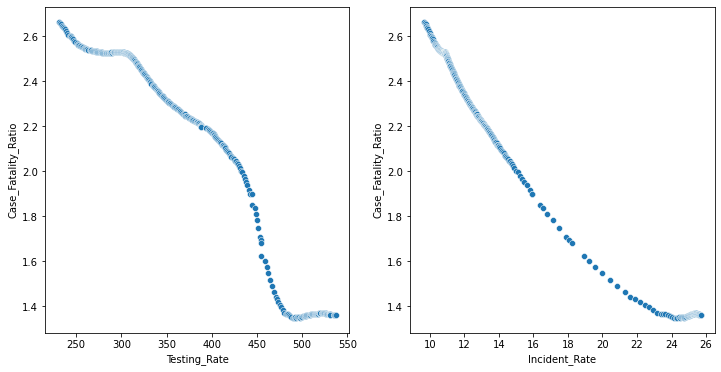

In [5]:
fig, axs = plt.subplots(figsize=(12,6), ncols=2)
data = merged_df.loc[merged_df['Province_State']=='New York']

sns.scatterplot(x=data['Testing_Rate'], y=data['Case_Fatality_Ratio'], ax=axs[0])
sns.scatterplot(data=data, x ='Incident_Rate', y='Case_Fatality_Ratio',ax=axs[1])

fig.savefig(figurepath+'linear_relationship_check.png')

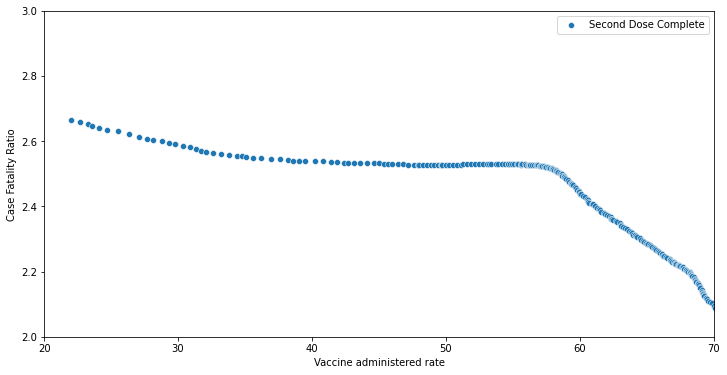

In [6]:
# plot the scatter plot to check relationship

fig, axs = plt.subplots(figsize=(12,6))
data = merged_df.loc[merged_df['Province_State']=='New York']

ax = sns.scatterplot(x=data['Series_Complete_Pop_Pct'], y=data['Case_Fatality_Ratio'], label='Second Dose Complete')

# ax = sns.scatterplot(data=data, x ='Administered_Dose1_Pop_Pct', y='Case_Fatality_Ratio', label='First Dose Complete')

# ax = sns.scatterplot(data=data, x ='Additional_Doses_Vax_Pct', y='Case_Fatality_Ratio',label='Booster Dose Complete')

ax.set(xlabel='Vaccine administered rate', ylabel='Case Fatality Ratio', xlim=(20,70), ylim=(2,3))

fig.savefig(figurepath+'vaccine_second_dose_linear_relationship.png')

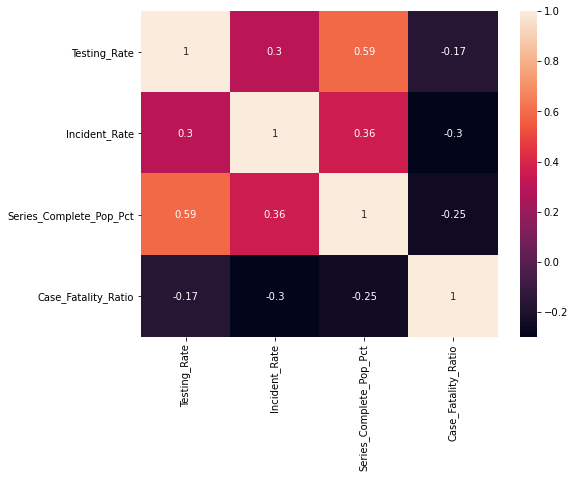

In [7]:
cols2 = ['Testing_Rate','Incident_Rate','Series_Complete_Pop_Pct', 'Case_Fatality_Ratio']
correlation_mat = merged_df[cols2].corr()
fig, axs = plt.subplots(figsize=(8,6))
ax = sns.heatmap(correlation_mat, annot = True)
plt.show()

fig.savefig(figurepath+'heatmap_between_variables.png')

By plotting the heatmap between target variable and other variables, we can see our chosen features are negatively correlated with the target variables.

## 1.2 Choosing lagging time window

we would like to investigate the lagging effect of covid-19 vaccine. We want to find out how soon after getting the COVID-19 vaccine will people start building immunity. And we can approch this problem by inspecting the relationship between case fatality ratio and vaccine administerned accumulated with different time gap after the second shot. For example, we can try out different time window from 0 days all the way to 160 days and see which time window vaccine data show the strongest correlation with the case fatality ratio. 


In [8]:
def lagging_window_column(df, lagging_window):
    '''
    create new series: shift fulluy vaccinated percent of population column in each group (states) n days
    '''
    new_series = df.groupby('Province_State')['Series_Complete_Pop_Pct'].shift(lagging_window)

    return new_series

In [9]:
def linear_reg(data, labels): # linear model
  reg = linear_model.LinearRegression()
  reg.fit(data, labels)
  return reg

**The best lagging window for immunity buildup after completion of vaccine dose varied across different states and region.** This may be caused by different data collection process and other social or economic factors or demographic difference. Thus, we choose to use data of California to choose lagging window and build models. But it should be generalized into other regions that have similar conditions with California State.

Maximum r2 value is: 0.5929599026068838, and corresponding lagging window is 80


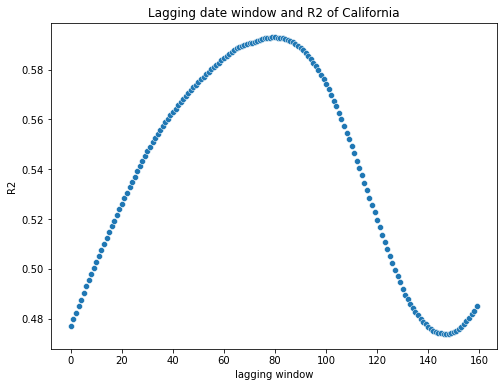

In [10]:
# df = merged_df.copy()

df = merged_df[merged_df['Province_State']=='California']
r2_score_lst = []
max_r2, cur_window = 0, 0

for window in range(0,160):

    # X = df[['Testing_Rate','Incident_Rate']].values
    y = df['Case_Fatality_Ratio'].values

    new_series = lagging_window_column(df, window)
    new_series = new_series.values
    new_series = new_series.reshape(-1,1)

    y = y.reshape(-1,1)

    # run linear model
    # calculate r2 score
    data = np.hstack((new_series, y))

    data = data[~np.isnan(data).any(axis=1), :] # remove nan row to fit
    X = data[:, :-1] # features: incident rate, testing_rate, new_lagging data
    y = data[:,-1] # target: case fatality ratio

    
    reg = linear_reg(X, y)
    r2_score = reg.score(X, y)
    if(r2_score > max_r2):
        max_r2 = r2_score
        cur_window = window
    r2_score_lst.append(r2_score)

fig, axs = plt.subplots(figsize=(8,6))
ax = sns.scatterplot(x=range(0,160), y=r2_score_lst) # plot to find best r2 and corresponding window
ax.set(xlabel='lagging window', ylabel='R2', title='Lagging date window and R2 of California')
print(f'Maximum r2 value is: {max_r2}, and corresponding lagging window is {cur_window}')

fig.savefig(figurepath+'Lagging date window and R2 of California')

## 1.3 Final Feature selection

After we decided on our vaccine administered lagging window, we can add new column as feature to represent. So the final feature columns we have chosen are the testing rate, the incident rate and second dose completion rate before shifted by days which is indicated by given time window.

In [11]:

selected_columns = ['Province_State','date','Testing_Rate','Incident_Rate','Series_Complete_Pop_Pct']

# add new column with 80 lagging window data
lagging_window_choice = 80

merged_df[f'Series_Complete_Pop_Pct_lag_{lagging_window_choice}_days'] = lagging_window_column(merged_df, lagging_window_choice)
selected_columns = ['Province_State','date','Testing_Rate','Incident_Rate','Series_Complete_Pop_Pct',f'Series_Complete_Pop_Pct_lag_{lagging_window_choice}_days', 'Case_Fatality_Ratio']
# selected_columns = cols1

model_data = merged_df[selected_columns].copy()


## 1.4 Train-Test data split

After we have constructed our design matrix of features for prediction, we can separate our dataset as training and testing set for different purposes. Since we will not be incorporating timeseries related behaviour when modeling, we can use random shuffling method to split our data.

In [12]:
# select california state data
model_data = model_data.loc[(model_data[f'Series_Complete_Pop_Pct_lag_{lagging_window_choice}_days'].notna())& (model_data['Province_State']=='California') ]

# train-test split

X = model_data[['Testing_Rate','Incident_Rate',f'Series_Complete_Pop_Pct_lag_{lagging_window_choice}_days']]
# X = model_data[cols1].drop(['Case_Fatality_Ratio','Province_State'], axis=1)
y = model_data['Case_Fatality_Ratio']

from sklearn.model_selection import train_test_split

split_dataset = train_test_split(X, y,
                                test_size=0.3,
                                 random_state=100)
X_train = split_dataset[0]
X_test = split_dataset[1]
y_train = split_dataset[2]
y_test = split_dataset[3]
X_train


Testing_Rate  Incident_Rate  Series_Complete_Pop_Pct_lag_80_days
1828    392.082982      23.044717                                 68.7
1606    198.638419      10.947230                                 47.4
1689    267.545220      12.646689                                 57.4
1624    214.457678      11.524603                                 51.4
1669    252.275927      12.319940                                 55.5
...            ...            ...                                  ...
1610    201.738791      11.074477                                 48.4
1597    192.457893      10.600667                                 45.4
1623    213.637299      11.502360                                 51.3
1824    388.099991      23.005182                                 68.5
1552    175.449708       9.837675                                 24.6

[200 rows x 3 columns]

# 2 Linear Regression Model

After this step, we can build models with most relevant features and predict cast fatality ratio and evaluate our model.
We would try out Linear model first. At the beginning, we want to try the simplest OLS model to see whether it perform well. And we will then try Ridge and LASSO regression to apply regularization to optimize our linear model and relect the best hyperparameter with Cross Validation step.


## 2.1 OLS Linear Regression

In [13]:

reg = linear_reg(X_train, y_train)
r2_score = reg.score(X_train, y_train)
print(f'OLS Linear model Training R2: {r2_score}')
print('Coefficients: {}\n'.format(repr(reg.coef_)))
print('Intercept: {}\n'.format(reg.intercept_))

predictions = reg.predict(X_test)

from sklearn import metrics
r2 = metrics.r2_score(y_test, predictions)
print('Test set R2: {}\n'.format(r2))
mse = metrics.mean_squared_error(
  y_test, predictions)
print('Test set MSE: {}\n'.format(mse))
mae = metrics.mean_absolute_error(
  y_test, predictions)
print('Test set MAE: {}\n'.format(mae))

OLS Linear model Training R2: 0.9887207783646381
Coefficients: array([ 0.00173401, -0.06507739, -0.00507164])

Intercept: 2.104538392757421

Test set R2: 0.9852271178443136

Test set MSE: 0.0008502613053037955

Test set MAE: 0.020559580358914257



## 2.2 Ridge Regression with CV

We use ridge regression here to lessen the influence of colinearity between features, and we use cross validation to choose from alpha value to make better models.

In [14]:
# uses the RidgeCV object of the linear_model module

alphas = np.linspace(0.01, 1.0, 100)

def cv_ridge_reg(data, labels, alphas):
  reg = linear_model.RidgeCV(alphas=alphas)
  reg.fit(data, labels)
  return reg


reg = cv_ridge_reg(X_train, y_train, alphas)
r2_score = reg.score(X_train, y_train)
print(f'Ridge regression Linear model Training R2: {r2_score}')
print('Coefficients: {}\n'.format(repr(reg.coef_)))
print('Intercept: {}\n'.format(reg.intercept_))
print('Chosen alpha: {}\n'.format(reg.alpha_))
predictions = reg.predict(X_test)

from sklearn import metrics
r2 = metrics.r2_score(y_test, predictions)
print('Test set R2: {}\n'.format(r2))
mse = metrics.mean_squared_error(
  y_test, predictions)
print('Test set MSE: {}\n'.format(mse))
mae = metrics.mean_absolute_error(
  y_test, predictions)
print('Test set MAE: {}\n'.format(mae))



Ridge regression Linear model Training R2: 0.9887204099729598
Coefficients: array([ 0.00172415, -0.06496327, -0.00505515])

Intercept: 2.104631449170415

Chosen alpha: 0.5800000000000001

Test set R2: 0.9852331541053576

Test set MSE: 0.0008499138850008201

Test set MAE: 0.02058844965199876



## 2.3 LASSO Regression with CV

lasso regression can select subset of features by zero out some weight coefficient. It can serve as a good way to select features when given too much features. In our case, according to LASSO liner model result, our coefficients are not set to be zero, which means they are all important features.



In [15]:

alphas = [0.01, 0.02, 0.03, 0.04, 0.05]

def cv_lasso_reg(data, labels, alphas):
  reg = linear_model.LassoCV(alphas=alphas)
  reg.fit(data, labels)
  return reg

reg = cv_lasso_reg(X_train, y_train, alphas)
r2_score = reg.score(X_train, y_train)
print(f'LASSO regression Linear model Training R2: {r2_score}')
print('Coefficients: {}\n'.format(repr(reg.coef_)))
print('Intercept: {}\n'.format(reg.intercept_))
print('Chosen alpha: {}\n'.format(reg.alpha_))
predictions = reg.predict(X_test)

r2 = metrics.r2_score(y_test, predictions)
print('Test set R2: {}\n'.format(r2))
mse = metrics.mean_squared_error(
  y_test, predictions)
print('Test set MSE: {}\n'.format(mse))
mae = metrics.mean_absolute_error(
  y_test, predictions)
print('Test set MAE: {}\n'.format(mae))


LASSO regression Linear model Training R2: 0.9871291151363962
Coefficients: array([ 0.00104753, -0.05774409, -0.00368099])

Intercept: 2.1068996751889375

Chosen alpha: 0.01

Test set R2: 0.9839224701565314

Test set MSE: 0.000925351015915767

Test set MAE: 0.024042286668189698



# 3 Decision Tree Model

After linear model, we would also try out decision tree model with cross validation to see if we can further increase our prediction accuracy.

## 3.1 Hyperparameter Tuning

For decision trees, we can tune the tree's maximum depth hyperparameter (max_depth) by using K-Fold cross-validation.

In [16]:


from sklearn.model_selection import cross_val_score

# Predefined data and labels


def cv_decision_tree(is_clf, data, labels,
                     max_depth, cv):
  '''
  calculate K fold cv scores
  '''
  if is_clf:
    d_tree = tree.DecisionTreeClassifier(max_depth=max_depth)
  else:
    d_tree = tree.DecisionTreeRegressor(max_depth=max_depth)
  scores = cross_val_score(d_tree, data, labels, cv=cv)
  return scores


is_clf = False  # for classification
for depth in range(1, 16):
  # Predefined data and labels
  scores = cv_decision_tree(
    is_clf, X_train, y_train, depth, 10)  # k = 10
  mean = scores.mean()  # Mean acc across folds
  std_2 = 2 * scores.std()  # 2 std devs
  print('95% C.I. for depth {}: {} +/- {:.2f}\n'.format(
    depth, mean, std_2))
  


dt_regressor = tree.DecisionTreeRegressor(random_state=0)

from sklearn.model_selection import GridSearchCV
reg = dt_regressor

params = {
  'max_depth':[1,2,3,4,5,6,7,8,9,10]
}
reg_cv = GridSearchCV(reg, params, cv=10)

# predefined train and test sets
reg_cv.fit(X_train, y_train)
print(reg_cv.best_params_)

95% C.I. for depth 1: 0.9066935737096271 +/- 0.07

95% C.I. for depth 2: 0.9812521206722922 +/- 0.01

95% C.I. for depth 3: 0.9917295248913811 +/- 0.01

95% C.I. for depth 4: 0.9968857799837622 +/- 0.00

95% C.I. for depth 5: 0.9979745749276863 +/- 0.00

95% C.I. for depth 6: 0.9984392576744561 +/- 0.00

95% C.I. for depth 7: 0.9985843457608258 +/- 0.00

95% C.I. for depth 8: 0.9988382880758644 +/- 0.00

95% C.I. for depth 9: 0.9987344595437717 +/- 0.00

95% C.I. for depth 10: 0.9989172026379913 +/- 0.00

95% C.I. for depth 11: 0.9989370860492075 +/- 0.00

95% C.I. for depth 12: 0.9989254452166065 +/- 0.00

95% C.I. for depth 13: 0.9984435492916012 +/- 0.00

95% C.I. for depth 14: 0.9981379849887319 +/- 0.00

95% C.I. for depth 15: 0.9988503690719286 +/- 0.00

{'max_depth': 10}


## 3.2 Model Fitting

In [17]:
# we choose the hyper parameter max depth according to cv result
max_depth = 10

dt_regressor = tree.DecisionTreeRegressor(random_state=0, max_depth=max_depth)
scores = cross_val_score(dt_regressor, X_train, y_train, cv=10)
print('Average validation scores: ', scores.mean())

dt_regressor.fit(X_train, y_train)
dt_regressor_train_accuracy = dt_regressor.score(X_train, y_train)
dt_regressor_test_accuracy = dt_regressor.score(X_test, y_test)

print('Training set r2: ', dt_regressor_train_accuracy)
print('Test set r2: ', dt_regressor_test_accuracy)


predictions = dt_regressor.predict(X_test)

mse = metrics.mean_squared_error(
  y_test, predictions)
print('Decision Tree test set MSE: {}\n'.format(mse))
mae = metrics.mean_absolute_error(
  y_test, predictions)
print('Decision Tree test set MAE: {}\n'.format(mae))

Average validation scores:  0.9990847507653713
Training set r2:  0.9999849196088871
Test set r2:  0.998963090015683
Decision Tree test set MSE: 5.967992078029358e-05

Decision Tree test set MAE: 0.003803714286050756



# 4 Random Forest Model

In this step, we need to use grid search methods to looking for best hyperparameters from sets of parameters provided for searching.

## 4.1 Hyperparameter Tuning

In [18]:
from sklearn.ensemble import RandomForestRegressor

grid_values = {'max_features': np.linspace(1,3,3, dtype='int32'),
               'min_samples_leaf': [5,6,7,8,9,10],
               'n_estimators': [100,200,300,400,500],
               'random_state': [88]} 

tic = time.time()

rf = RandomForestRegressor() 
rf_cv = GridSearchCV(rf, param_grid=grid_values, cv=5)
rf_cv.fit(X_train, y_train)

print(rf_cv.best_params_)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

{'max_features': 1, 'min_samples_leaf': 5, 'n_estimators': 200, 'random_state': 88}
time: 82.01 s


## 4.2 Model Fitting

In [19]:
# choose parameters as cv results
max_features = 1
min_samples_leaf = 5
n_estimators = 200

rf_regressor = RandomForestRegressor(random_state=88, 
                                     max_features=max_features,
                                     min_samples_leaf=min_samples_leaf,
                                     n_estimators=n_estimators)

scores = cross_val_score(rf_regressor, X_train, y_train, cv=10)
print('Random Forest average validation r2 scores: ', scores.mean())

rf_regressor.fit(X_train, y_train)
rf_regressor_train_accuracy = rf_regressor.score(X_train, y_train)
rf_regressor_test_accuracy = rf_regressor.score(X_test, y_test)

print('Training set r2: ', rf_regressor_train_accuracy)
print('Test set r2: ', rf_regressor_test_accuracy)

predictions = rf_regressor.predict(X_test)

mse = metrics.mean_squared_error(
  y_test, predictions)
print('Random Forest test set MSE: {}\n'.format(mse))
mae = metrics.mean_absolute_error(
  y_test, predictions)
print('Random Forest test set MAE: {}\n'.format(mae))

Random Forest average validation r2 scores:  0.9978301138246314
Training set r2:  0.9987379985688959
Test set r2:  0.9971419327019294
Random Forest test set MSE: 0.00016449762516843744

Random Forest test set MAE: 0.006608678044822162



# 5 Choosing final model

* Since our goal is to use model to provide insights regarding pandemic data. It should be clearly explaining relationship between case fatality ratio and our chosen variables. In this sense, the linear models is the best candidate, especially for Ridge linear regression, it is not prone to overfit with the regularization term. At the same time, it did not have significantly worse performance compared with other non-linear models evaluated with R2, MSE and MAE. Therefore, we should choose Ridge linear regression model over decision tree model and random forest model.

